In [1]:
import pandas as pd
import sqlite3
from bootcampviztools import *
import matplotlib.pyplot as plt

In [2]:
def sql_query(query):

    # Ejecuta la query
    cursor_clase.execute(query)
                                    

    # Almacena los datos de la query 
    ans = cursor_clase.fetchall()

    # Obtenemos los nombres de las columnas de la tabla
    names = [description[0] for description in cursor_clase.description]

    return pd.DataFrame(ans,columns=names)

### Hipótesis: A partir del 2015 (primer anillo de los GSW), la NBA se compone de:
1. Más triples, con un mayor porcentaje de acierto
2. Menos tiros de 2 y menos pts de media distancia, lo considerado ahora menos eficiente
3. Más contraataques
4. Menos juego interior y en la zona
5. Partidos con más puntos

In [3]:
#Dataframes de jugadores
players = pd.read_csv("./data/archive/csv/player.csv")
player_info = pd.read_csv("./data/archive/csv/common_player_info.csv")

#Dataframes de partidos
game = pd.read_csv("./data/archive/csv/game.csv")
game_summary = pd.read_csv("./data/archive/csv/game_summary.csv")
line_score = pd.read_csv("./data/archive/csv/line_score.csv")
other_stats = pd.read_csv("./data/archive/csv/other_stats.csv") #de 1946 a 2022

#Dataframes de equipos
team = pd.read_csv("./data/archive/csv/team.csv")


La base de datos que encontré tenía distintos csv:

- player: los jugadores que hay
- game_summary: resultado de los partidos de 1946 a 2022
- line_score: todos los partidos y los puntos por cuarto
- game: todos los partidos, quién jugo, porcentaje de tiros acertados, de 3, libres...
- other_stats: todos los partidos y los tipos de puntos (en pintura, 2a oportunidad, en contraataque), asistencias, rebotes y pérdidas totales...
- play_by_play: todos los eventos de cada partidos, hechos por x jugador en x minuto
------
- draft_combine_stats: todos los jugadores drafteados con sus características (de 2004 a 2023 sin 2006, 2016 y 2021)
- Common_player_info: todos los jugadores por orden alfabético y qué temporadas estuvieron
- draft_history: datos del draft históricos
- team: los equipos que existen

### Other_stats es lo que me dará los puntos y los análisis necesarios. 
### La diferencia de los puntos totales menos los triples, fast breaks (contraataque) y tiros libres son los tiros de media distancia

In [4]:
# Conectamos con la base de datos
connection = sqlite3.connect("./data/archive/nba.sqlite")
# Obtenemos un cursor que utilizaremos para hacer las queries
cursor_clase = connection.cursor()

In [367]:
game_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58110 entries, 0 to 58109
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   game_date_est                     58110 non-null  object 
 1   game_sequence                     32578 non-null  float64
 2   game_id                           58110 non-null  int64  
 3   game_status_id                    58110 non-null  int64  
 4   game_status_text                  32124 non-null  object 
 5   gamecode                          58110 non-null  object 
 6   home_team_id                      58110 non-null  int64  
 7   visitor_team_id                   58110 non-null  int64  
 8   season                            58110 non-null  int64  
 9   live_period                       58110 non-null  int64  
 10  live_pc_time                      2024 non-null   object 
 11  natl_tv_broadcaster_abbreviation  6203 non-null   object 
 12  live

In [369]:
game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65698 entries, 0 to 65697
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   season_id               65698 non-null  int64  
 1   team_id_home            65698 non-null  int64  
 2   team_abbreviation_home  65698 non-null  object 
 3   team_name_home          65698 non-null  object 
 4   game_id                 65698 non-null  int64  
 5   game_date               65698 non-null  object 
 6   matchup_home            65698 non-null  object 
 7   wl_home                 65696 non-null  object 
 8   min                     65698 non-null  int64  
 9   fgm_home                65685 non-null  float64
 10  fga_home                50251 non-null  float64
 11  fg_pct_home             50208 non-null  float64
 12  fg3m_home               52480 non-null  float64
 13  fg3a_home               47015 non-null  float64
 14  fg3_pct_home            46624 non-null

### Hago la query en SQL

In [5]:
query = '''
SELECT a.matchup_home as Partido, b.team_abbreviation_home as Local, b.team_abbreviation_away as Visitante, c.season as "Temporada",
a.pts_home as "Puntos Local", a.pts_away as "Puntos Visitante",
b.pts_paint_home as "Puntos en zona Local", b.pts_2nd_chance_home as "Puntos 2a oportunidad Local", b.pts_fb_home as "Puntos en transición Local", 
a.fg3m_home as "Triples Local", a.fg3a_home as "Triples intentados Local", a.fg3_pct_home as "% triples Local",
a.ftm_home as "Tiros libres Local", a.fta_home as "Tiros libres intentados Local", a.ft_pct_home as "% tiros libres Local",
b.pts_paint_away as "Puntos en zona Visitante", b.pts_2nd_chance_away as "Puntos 2a oportunidad Visitante", b.pts_fb_away as "Puntos en transición Visitante", 
a.fg3m_away as "Triples Visitante", a.fg3a_away as "Triples intentados Visitante", a.fg3_pct_away as "% triples Visitante",
a.ftm_away as "Tiros libres Visitante", a.fta_away as "Tiros libres intentados Visitante", a.ft_pct_away as "% tiros libres Visitante"
FROM game as A
LEFT JOIN other_stats as B
ON a.game_id = b.game_id
LEFT JOIN game_summary as C
ON c.game_id = a.game_id
WHERE c.season BETWEEN 2006 AND 2022
'''
nba = sql_query(query)
nba

,Partido,Local,Visitante,Temporada,Puntos Local,Puntos Visitante,Puntos en zona Local,Puntos 2a oportunidad Local,Puntos en transición Local,Triples Local,...,% tiros libres Local,Puntos en zona Visitante,Puntos 2a oportunidad Visitante,Puntos en transición Visitante,Triples Visitante,Triples intentados Visitante,% triples Visitante,Tiros libres Visitante,Tiros libres intentados Visitante,% tiros libres Visitante
0,LAL vs. PHX,LAL,PHX,2006,114.0,106.0,66.0,9.0,25.0,6.0,...,0.667,34.0,8.0,20.0,13.0,30.0,0.433,13.0,17.0,0.765
1,MIA vs. CHI,MIA,CHI,2006,66.0,108.0,26.0,2.0,6.0,3.0,...,0.591,36.0,18.0,21.0,7.0,13.0,0.538,23.0,32.0,0.719
2,MEM vs. NYK,None,None,2006,117.0,118.0,NaN,NaN,NaN,6.0,...,0.600,NaN,NaN,NaN,10.0,22.0,0.455,28.0,36.0,0.778
3,NJN vs. TOR,TOR,NJN,2006,102.0,92.0,40.0,13.0,21.0,3.0,...,0.792,44.0,10.0,20.0,4.0,20.0,0.200,14.0,20.0,0.700
4,ORL vs. CHI,CHI,ORL,2006,109.0,94.0,38.0,11.0,9.0,6.0,...,0.786,44.0,10.0,17.0,6.0,20.0,0.300,14.0,24.0,0.583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20044,LBN vs. GNS,LBN,GNS,2022,175.0,184.0,118.0,15.0,27.0,17.0,...,NaN,88.0,14.0,33.0,29.0,66.0,0.439,3.0,4.0,0.750
20045,LBN vs. GNS,LBN,GNS,2022,175.0,184.0,118.0,15.0,27.0,17.0,...,NaN,88.0,14.0,33.0,29.0,66.0,0.439,3.0,4.0,0.750
20046,LBN vs. GNS,LBN,GNS,2022,175.0,184.0,118.0,15.0,27.0,17.0,...,NaN,88.0,14.0,33.0,29.0,66.0,0.439,3.0,4.0,0.750
20047,LBN vs. GNS,LBN,GNS,2022,175.0,184.0,118.0,15.0,27.0,17.0,...,NaN,88.0,14.0,33.0,29.0,66.0,0.439,3.0,4.0,0.750


### Hay que eliminar los partidos del All-Star

In [6]:
nba = nba[nba["Local"] != "EST"]

In [7]:
nba = nba[nba["Visitante"] != "EST"]

In [8]:
nba = nba[nba["Visitante"] != "LBN"]

In [9]:
nba = nba[nba["Local"] != "LBN"]

In [10]:
nba = nba[nba["Partido"] != "WST vs. EST"]

In [154]:
nba.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19973 entries, 0 to 20040
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Partido                            19973 non-null  object 
 1   Local                              18283 non-null  object 
 2   Visitante                          18283 non-null  object 
 3   Temporada                          19973 non-null  object 
 4   Puntos Local                       19973 non-null  float64
 5   Puntos Visitante                   19973 non-null  float64
 6   Puntos en zona Local               18283 non-null  float64
 7   Puntos 2a oportunidad Local        18283 non-null  float64
 8   Puntos en transición Local         18283 non-null  float64
 9   Triples Local                      19973 non-null  float64
 10  Triples intentados Local           19973 non-null  float64
 11  % triples Local                    19973 non-null  float64


*CRIBADO (19973 datos)*
- Más triples, con un mayor porcentaje de acierto
- Partidos con más puntos
---
*NO CRIBADO (18283 datos)*
- Menos tiros de 2 y menos pts de media distancia, lo considerado ahora menos eficiente 
- Más contraataques
- Menos juego interior y en la zona


### Ahora creo la columna de tiros de 2 (media distancia)

In [11]:
nba["Puntos de media distancia Local"] = nba["Puntos Local"] - nba["Puntos en zona Local"] - nba["Tiros libres Local"] - nba["Triples Local"]
nba["Puntos de media distancia Visitante"] = nba["Puntos Visitante"] - nba["Puntos en zona Visitante"] - nba["Tiros libres Visitante"] - nba["Triples Visitante"]

De 2012 hay poquísimos datos por el lockdown (huelga de jugadores) y de 2019 faltan por la pandemia
--
#### Se calcula la cantidad de puntos de cada tipo por partido:

In [12]:
nba["Puntos en zona Total"] = nba["Puntos en zona Local"] + nba["Puntos en zona Visitante"]

nba["Puntos de media distancia Total"] = nba["Puntos de media distancia Local"] + nba["Puntos de media distancia Visitante"]

nba["Puntos de 3 Total"] = nba["Triples Local"]*3 + nba["Triples Visitante"]*3
nba["Triples encestados Total"] = nba["Triples Local"] + nba["Triples Visitante"]
nba["Triples intentados Total"] = nba["Triples intentados Local"] + nba["Triples intentados Visitante"]

nba["Puntos tiros libres Total"] = nba["Tiros libres Local"] + nba["Tiros libres Visitante"]
nba["Puntos en transición Total"] = nba["Puntos en transición Local"] + nba["Puntos en transición Visitante"]
nba["Puntos Total"] = nba["Puntos Local"] + nba["Puntos Visitante"]

#### Se sacan las cantidades totales de puntos por local y visitante

In [276]:
nba.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19973 entries, 0 to 20040
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Partido                              19973 non-null  object 
 1   Local                                18283 non-null  object 
 2   Visitante                            18283 non-null  object 
 3   Temporada                            19973 non-null  object 
 4   Puntos Local                         19973 non-null  float64
 5   Puntos Visitante                     19973 non-null  float64
 6   Puntos en zona Local                 18283 non-null  float64
 7   Puntos 2a oportunidad Local          18283 non-null  float64
 8   Puntos en transición Local           18283 non-null  float64
 9   Triples Local                        19973 non-null  float64
 10  Triples intentados Local             19973 non-null  float64
 11  % triples Local                  

- Hay 10217 resultados antes de 2015 y 9756 después de 2015

# Sería interesante hacer gráficas de evolución a lo largo de los años de los:
1. Tiros de 3 (puntos que vienen de triples, triples intentados, triples encestados)
2. Tiros de 2
3. Tiros en la zona
4. Puntos en transición
5. Puntuaciones

In [13]:
partidos_por_temporada = nba['Temporada'].value_counts()

In [206]:
partidos_por_temporada

Temporada
2010    1319
2013    1305
2014    1304
2015    1303
2016    1289
2007    1289
2009    1287
2017    1274
2008    1268
2006    1265
2021    1255
2022    1252
2018    1197
2020    1154
2019    1032
2011     997
2012     183
Name: count, dtype: int64

In [14]:
nba_agrupados = nba.groupby('Temporada').sum()

In [15]:
nba_agrupados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, 2006 to 2022
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Partido                              17 non-null     object 
 1   Local                                17 non-null     object 
 2   Visitante                            17 non-null     object 
 3   Puntos Local                         17 non-null     float64
 4   Puntos Visitante                     17 non-null     float64
 5   Puntos en zona Local                 17 non-null     float64
 6   Puntos 2a oportunidad Local          17 non-null     float64
 7   Puntos en transición Local           17 non-null     float64
 8   Triples Local                        17 non-null     float64
 9   Triples intentados Local             17 non-null     float64
 10  % triples Local                      17 non-null     float64
 11  Tiros libres Local                

In [16]:
nba_agrupados['Media Puntos'] = nba_agrupados['Puntos Total']/partidos_por_temporada

nba_agrupados['Media Puntos Triples'] = nba_agrupados['Puntos de 3 Total']/partidos_por_temporada
nba_agrupados['Media Triples intentados'] = nba_agrupados['Triples intentados Total']/partidos_por_temporada
nba_agrupados['Media Triples encestados'] = nba_agrupados['Triples encestados Total']/partidos_por_temporada

nba_agrupados['Media Puntos de media distancia'] = nba_agrupados['Puntos de media distancia Total']/partidos_por_temporada

nba_agrupados['Media Puntos Tiros Libres'] = nba_agrupados['Puntos tiros libres Total']/partidos_por_temporada

nba_agrupados['Media Puntos en Zona'] = nba_agrupados['Puntos en zona Total']/partidos_por_temporada

nba_agrupados['Media Puntos en Transición'] = nba_agrupados['Puntos en transición Total']/partidos_por_temporada

Me deshago de las columnas que no me interesan

In [17]:
nba_agrupados = nba_agrupados.drop(["Partido","Local","Visitante"], axis = 1)

In [18]:
nba_agrupados = nba_agrupados.reset_index()

In [296]:
nba_agrupados

,Temporada,Puntos Local,Puntos Visitante,Puntos en zona Local,Puntos 2a oportunidad Local,Puntos en transición Local,Triples Local,Triples intentados Local,% triples Local,Tiros libres Local,...,Triples intentados Total,Triples encestados Total,Media Puntos,Media Puntos Triples,Media Triples intentados,Media Triples encestados,Media Puntos de media distancia,Media Puntos Tiros Libres,Media Puntos en Zona,Media Puntos en Transición
0,2006,126390.0,122668.0,43168.0,13972.0,13038.0,7747.0,21533.0,446.264,25619.0,...,42931.0,15265.0,196.883794,36.201581,33.937549,12.067194,56.659289,39.825296,67.584190,20.607115
1,2007,130692.0,125886.0,44370.0,14717.0,13873.0,8432.0,23106.0,465.210,25330.0,...,46304.0,16688.0,199.051978,38.839410,35.922420,12.946470,60.167572,38.322731,69.140419,21.541505
2,2008,128084.0,124040.0,43188.0,14156.0,13322.0,8379.0,22798.0,461.838,25077.0,...,45919.0,16748.0,198.835962,39.624606,36.213722,13.208202,57.742902,38.401420,68.012618,20.779180
3,2009,130947.0,127007.0,47270.0,14684.0,15862.0,8230.0,23194.0,452.308,25199.0,...,46515.0,16467.0,200.430458,38.384615,36.142191,12.794872,58.138306,38.185703,72.777001,24.447552
4,2010,132902.0,128251.0,50072.0,16028.0,17350.0,8654.0,23938.0,469.721,25712.0,...,47499.0,16939.0,197.993177,38.526914,36.011372,12.842305,61.514784,38.027293,76.086429,25.991660
5,2011,97209.0,94088.0,37284.0,11835.0,12170.0,6415.0,18256.0,345.300,17496.0,...,36582.0,12733.0,191.872618,38.313942,36.692076,12.771314,58.353059,34.084253,74.866600,24.464393
6,2012,17738.0,17046.0,6932.0,2234.0,2256.0,1281.0,3658.0,63.761,3465.0,...,7409.0,2556.0,190.076503,41.901639,40.486339,13.967213,58.655738,36.338798,74.644809,23.743169
7,2013,132697.0,129341.0,51264.0,16025.0,16415.0,10046.0,27956.0,464.999,24077.0,...,56316.0,20160.0,200.795402,46.344828,43.154023,15.448276,61.687356,35.950958,78.079693,25.027586
8,2014,131863.0,128706.0,51202.0,15952.0,16370.0,10368.0,29335.0,456.639,23169.0,...,58700.0,20530.0,199.822853,47.231595,45.015337,15.743865,61.527607,34.907209,78.360429,24.880368
9,2015,135208.0,131264.0,52042.0,15529.0,16388.0,11250.0,31574.0,463.060,23846.0,...,63308.0,22276.0,204.506523,51.287797,48.586339,17.095932,63.203377,35.817345,79.737529,25.015349


- Creo el dataset de las medias por temporada

In [19]:
parte1 = nba_agrupados.iloc[:, 0].copy()
parte2 = nba_agrupados.iloc[:, 30:].copy()
nba_medias = pd.concat([parte1, parte2], axis=1)

In [20]:
nba_medias.set_index('Temporada')

,Puntos Total,Media Puntos,Media Puntos Triples,Media Triples intentados,Media Triples encestados,Media Puntos de media distancia,Media Puntos Tiros Libres,Media Puntos en Zona,Media Puntos en Transición
Temporada,,,,,,,,,
2006,249058.0,196.883794,36.201581,33.937549,12.067194,56.659289,39.825296,67.584190,20.607115
2007,256578.0,199.051978,38.839410,35.922420,12.946470,60.167572,38.322731,69.140419,21.541505
2008,252124.0,198.835962,39.624606,36.213722,13.208202,57.742902,38.401420,68.012618,20.779180
2009,257954.0,200.430458,38.384615,36.142191,12.794872,58.138306,38.185703,72.777001,24.447552
2010,261153.0,197.993177,38.526914,36.011372,12.842305,61.514784,38.027293,76.086429,25.991660
2011,191297.0,191.872618,38.313942,36.692076,12.771314,58.353059,34.084253,74.866600,24.464393
2012,34784.0,190.076503,41.901639,40.486339,13.967213,58.655738,36.338798,74.644809,23.743169
2013,262038.0,200.795402,46.344828,43.154023,15.448276,61.687356,35.950958,78.079693,25.027586
2014,260569.0,199.822853,47.231595,45.015337,15.743865,61.527607,34.907209,78.360429,24.880368


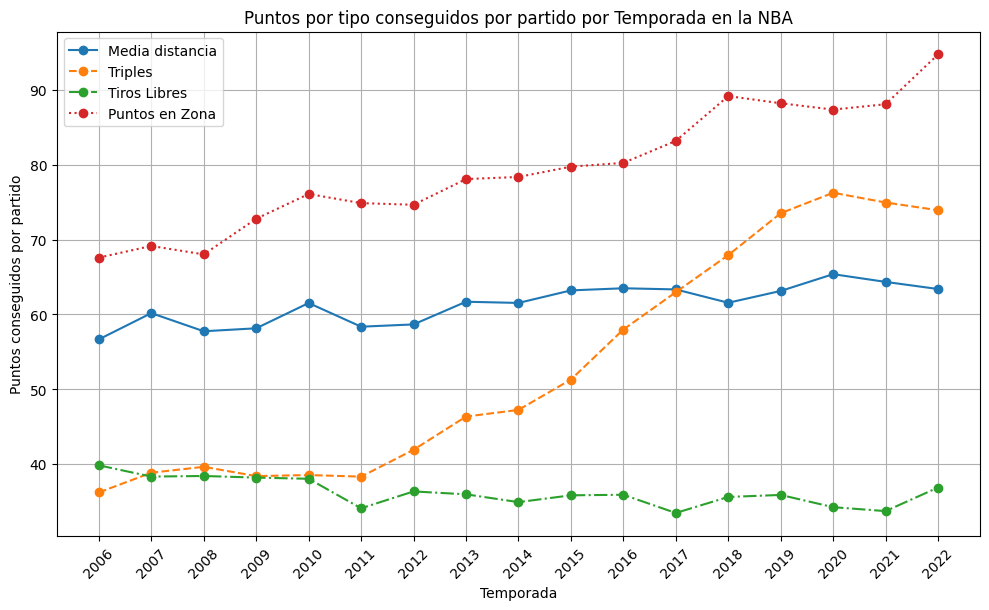

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(nba_medias.Temporada, nba_medias['Media Puntos de media distancia'], marker='o', linestyle='-', label = 'Media distancia')
plt.plot(nba_medias.Temporada, nba_medias['Media Puntos Triples'], marker='o', linestyle='--', label = 'Triples')
plt.plot(nba_medias.Temporada, nba_medias['Media Puntos Tiros Libres'], marker='o', linestyle='-.', label = 'Tiros Libres')
plt.plot(nba_medias.Temporada, nba_medias['Media Puntos en Zona'], marker='o', linestyle=':', label = 'Puntos en Zona')

plt.xlabel('Temporada')
plt.ylabel('Puntos conseguidos por partido')
plt.title('Puntos por tipo conseguidos por partido por Temporada en la NBA')
plt.grid(True)

plt.tight_layout()
plt.xticks(rotation=45)  # Rota las etiquetas del eje x para mayor legibilidad
plt.legend()
plt.show()

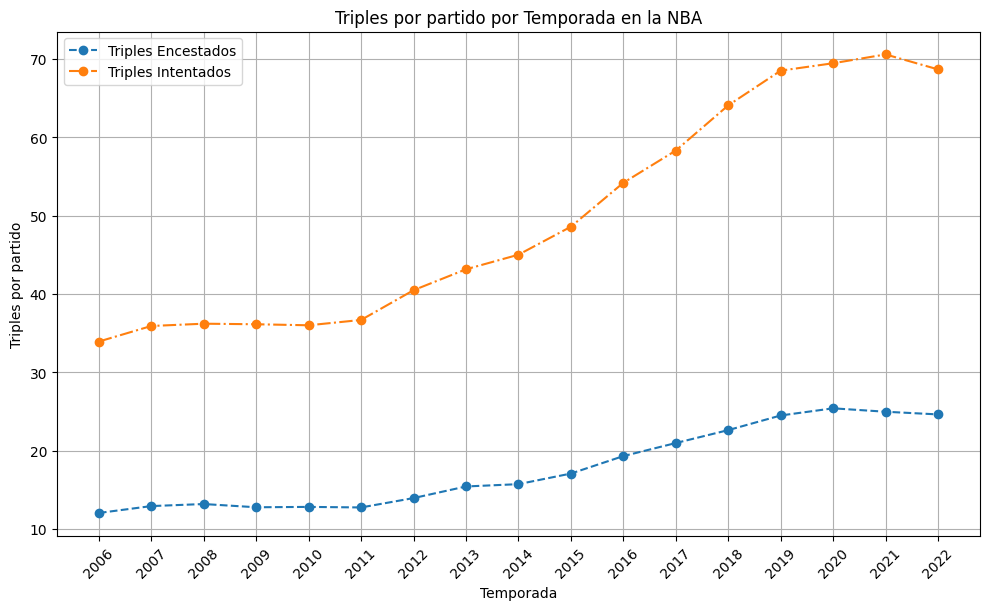

In [22]:
plt.figure(figsize=(10, 6))

plt.plot(nba_medias.Temporada, nba_medias['Media Triples encestados'], marker='o', linestyle='--', label = 'Triples Encestados')
plt.plot(nba_medias.Temporada, nba_medias['Media Triples intentados'], marker='o', linestyle='-.', label = 'Triples Intentados')

plt.xlabel('Temporada')
plt.ylabel('Triples por partido')
plt.title('Triples por partido por Temporada en la NBA')
plt.grid(True)

plt.tight_layout()
plt.xticks(rotation=45) 
plt.legend()
plt.show()

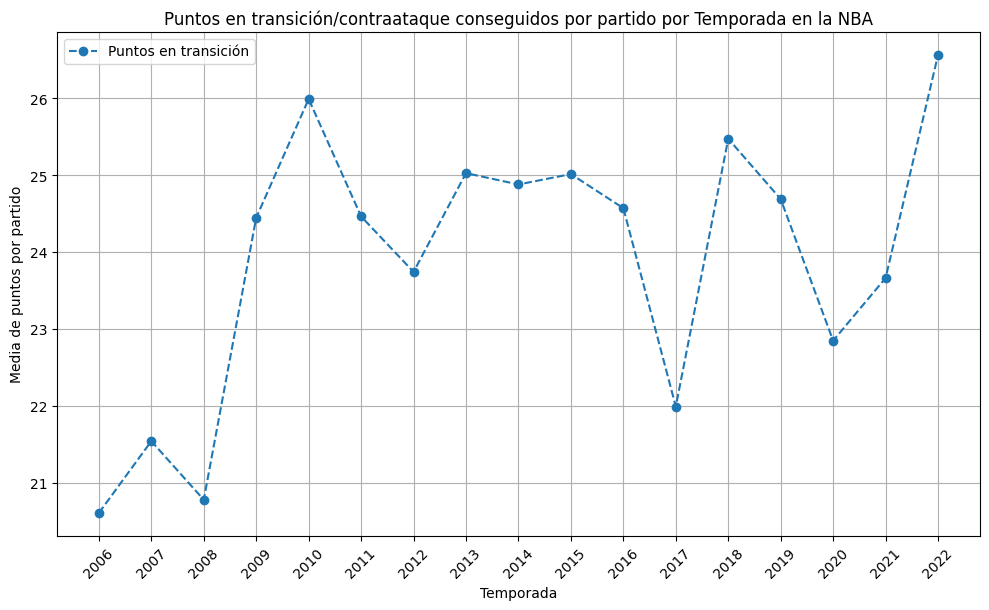

In [364]:
plt.figure(figsize=(10, 6))

plt.plot(nba_medias.Temporada, nba_medias['Media Puntos en Transición'], marker='o', linestyle='--', label = 'Puntos en transición')

plt.xlabel('Temporada')
plt.ylabel('Media de puntos por partido')
plt.title('Puntos en transición/contraataque conseguidos por partido por Temporada en la NBA')
plt.grid(True)

# Mostrar el gráfico
plt.tight_layout()
plt.xticks(rotation=45) 
plt.legend()
plt.show()

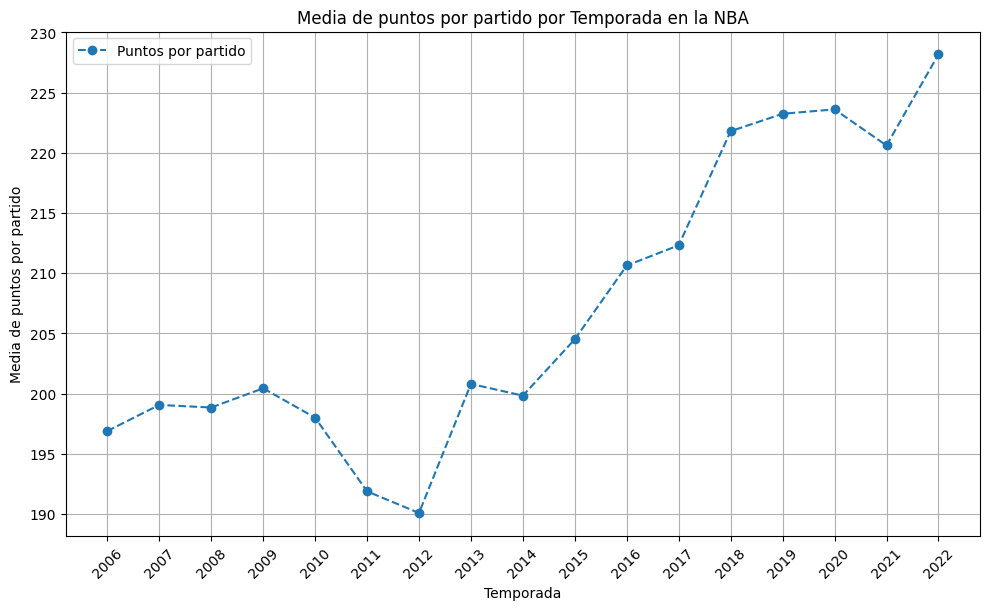

In [365]:
plt.figure(figsize=(10, 6))

plt.plot(nba_medias.Temporada, nba_medias['Media Puntos'], marker='o', linestyle='--', label = 'Puntos por partido')

plt.xlabel('Temporada')
plt.ylabel('Media de puntos por partido')
plt.title('Media de puntos por partido por Temporada en la NBA')
plt.grid(True)

# Mostrar el gráfico
plt.tight_layout()
plt.xticks(rotation=45) 
plt.legend()
plt.show()

### Sería interesante pie o bar charts de todas las temporadas y la composicion de los puntos por partido según tipos

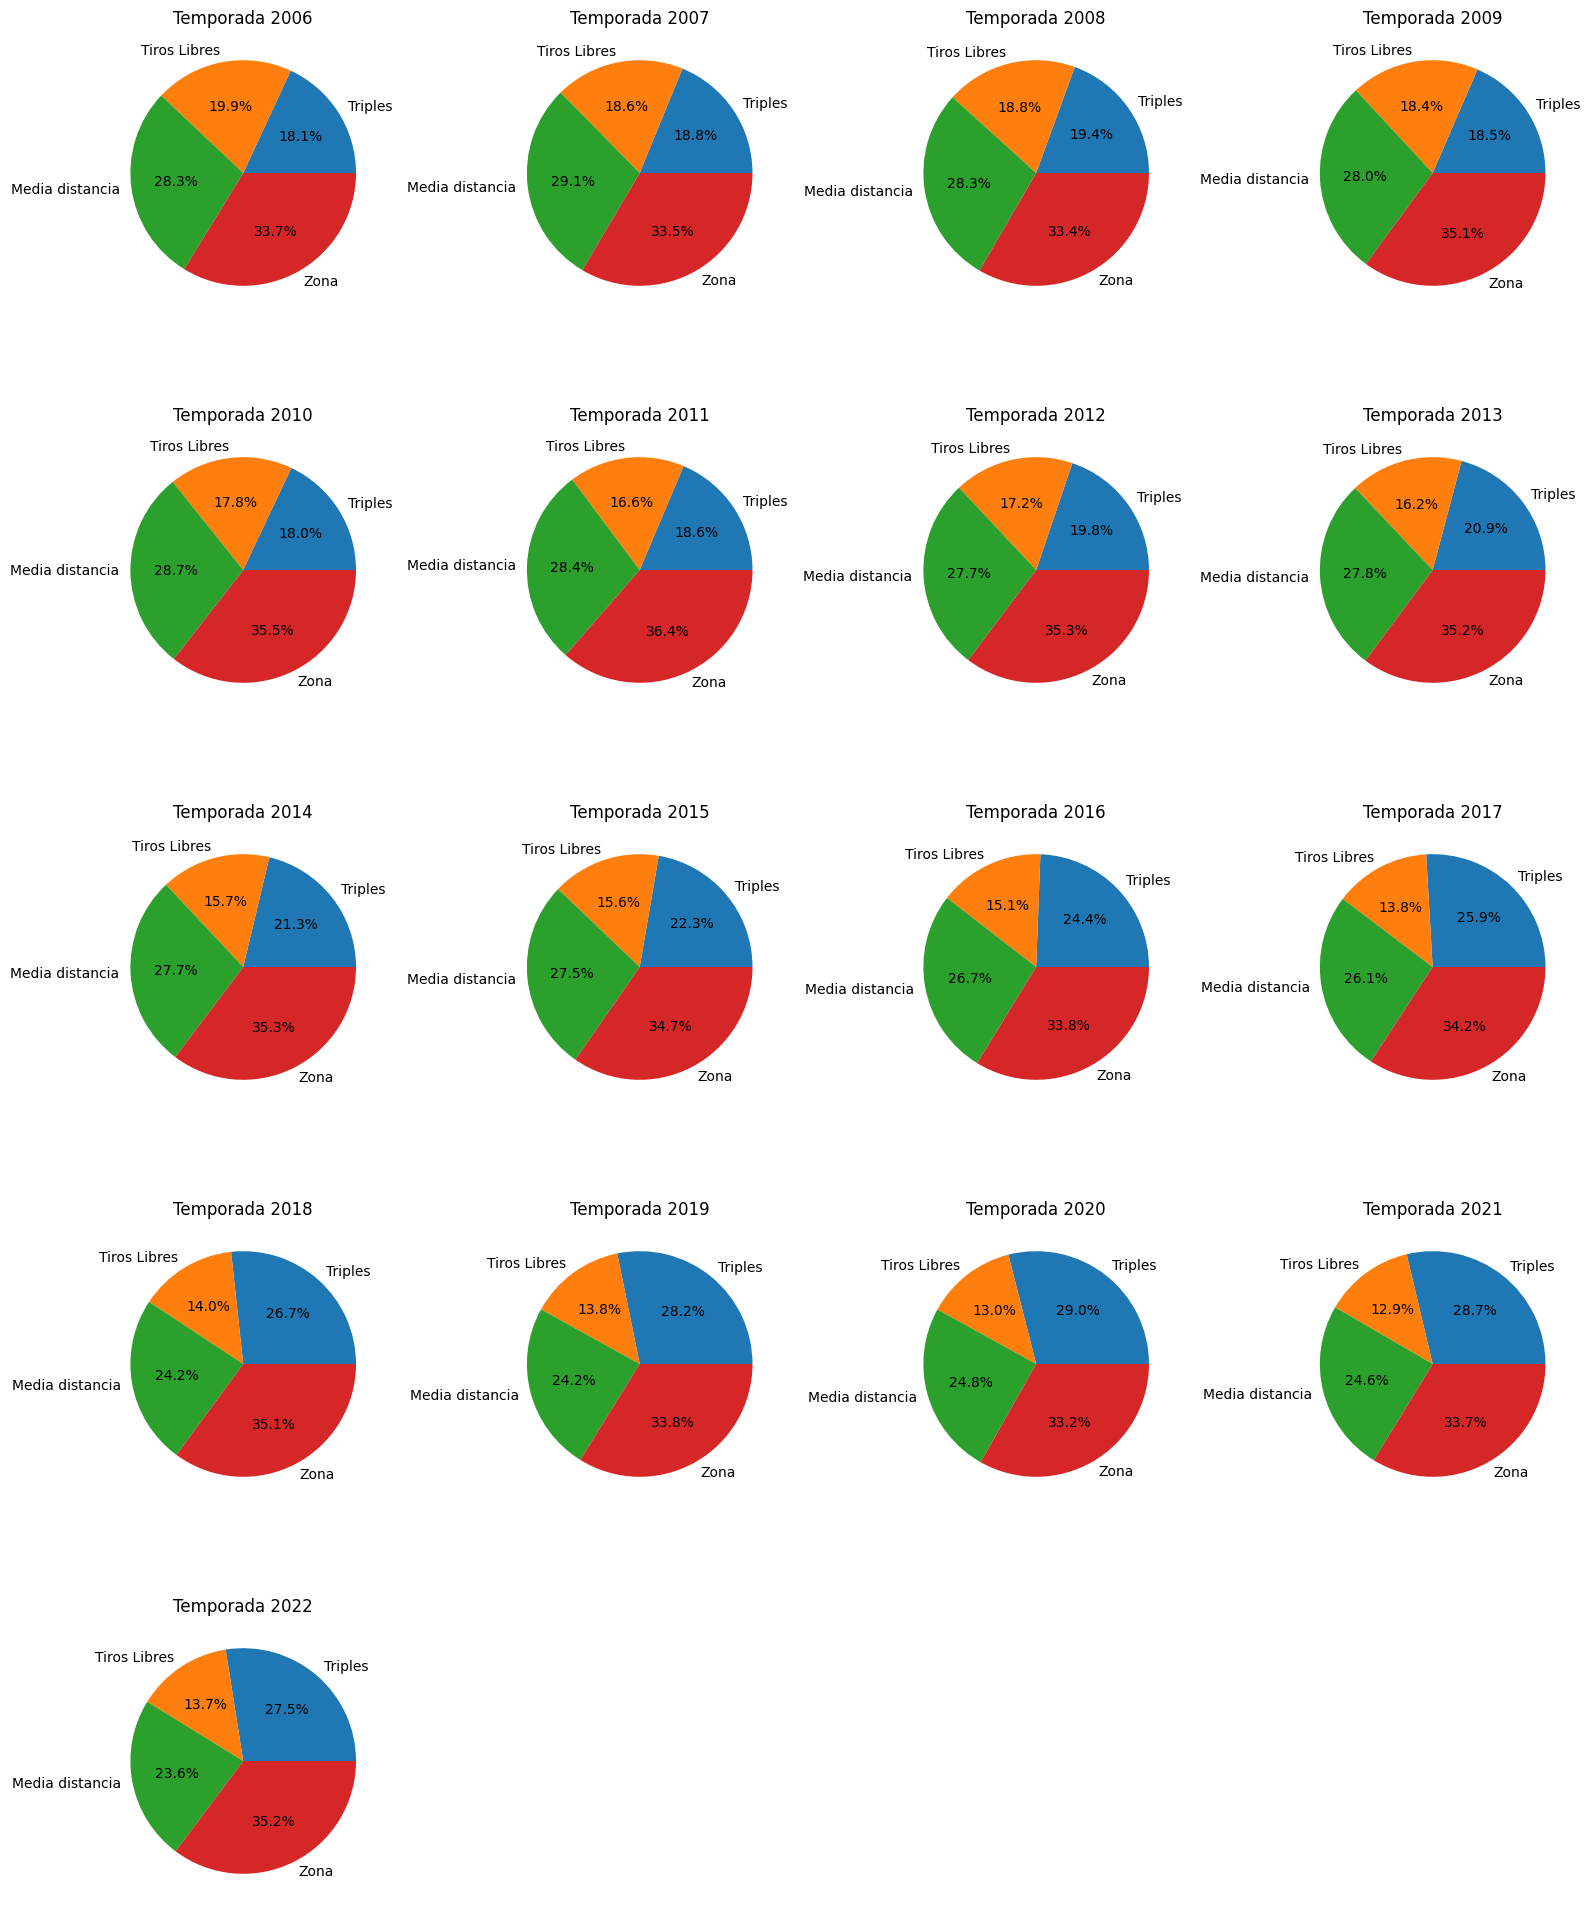

In [362]:

fig, axs = plt.subplots(5, 4, figsize=(16, 20))

for i in nba_agrupados.index:

    total_puntos_por_partido = nba_medias['Media Puntos'][i]
    puntos_por_partido_triples = nba_medias['Media Puntos Triples'][i] / total_puntos_por_partido
    puntos_por_partido_tiros_libres = nba_medias ['Media Puntos Tiros Libres'][i] / total_puntos_por_partido
    puntos_por_partido_tiros_de_2 = nba_medias['Media Puntos de media distancia'][i] / total_puntos_por_partido
    puntos_por_partido_tiros_en_zona = nba_medias['Media Puntos en Zona'][i] / total_puntos_por_partido
 
    ax = axs[i // 4, i % 4]
    ax.pie([puntos_por_partido_triples , puntos_por_partido_tiros_libres, puntos_por_partido_tiros_de_2, puntos_por_partido_tiros_en_zona],
            labels=['Triples', 'Tiros Libres', 'Media distancia', 'Zona'],
            autopct='%1.1f%%')
    ax.set_title(f'Temporada {2006+i}')
    ax.axis('equal')  # Asegura que el gráfico de pie sea un círculo
    
for i in range(17, 20):
    fig.delaxes(axs[i // 4, i % 4]) #eliminar los sobrantes que no se han pintado

plt.tight_layout()
plt.show()

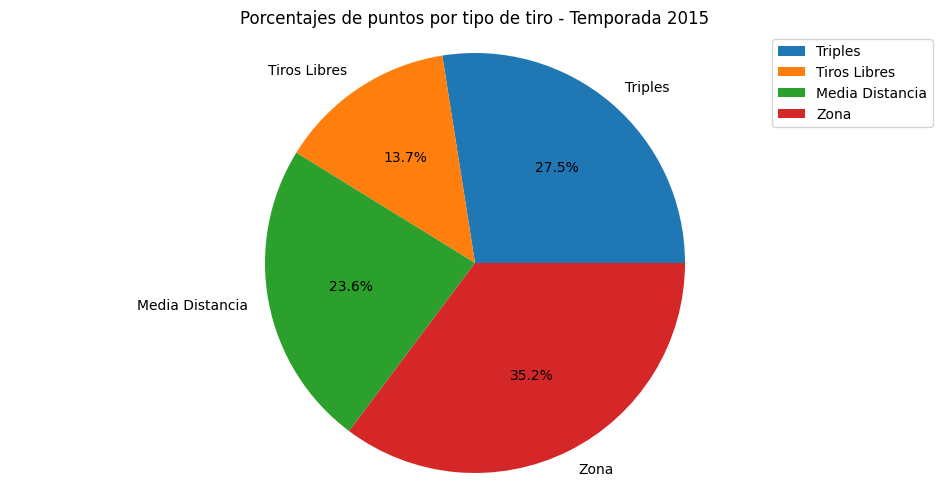

In [49]:
total_puntos_por_partido = nba_medias['Media Puntos'][16]
puntos_por_partido_triples = nba_medias['Media Puntos Triples'][16] / total_puntos_por_partido
puntos_por_partido_tiros_libres = nba_medias ['Media Puntos Tiros Libres'][16] / total_puntos_por_partido
puntos_por_partido_tiros_de_2 = nba_medias['Media Puntos de media distancia'][16] / total_puntos_por_partido
puntos_por_partido_tiros_en_zona = nba_medias['Media Puntos en Zona'][16] / total_puntos_por_partido

# Crear un gráfico de pie para la temporada concreta
plt.figure(figsize=(12,6))
plt.title(f'Porcentajes de puntos por tipo de tiro - Temporada 2015')
plt.pie([puntos_por_partido_triples , puntos_por_partido_tiros_libres, puntos_por_partido_tiros_de_2, puntos_por_partido_tiros_en_zona],
        labels=(['Triples', 'Tiros Libres', 'Media Distancia', 'Zona']),
        autopct='%1.1f%%')
plt.axis('equal')
plt.legend()
plt.show()

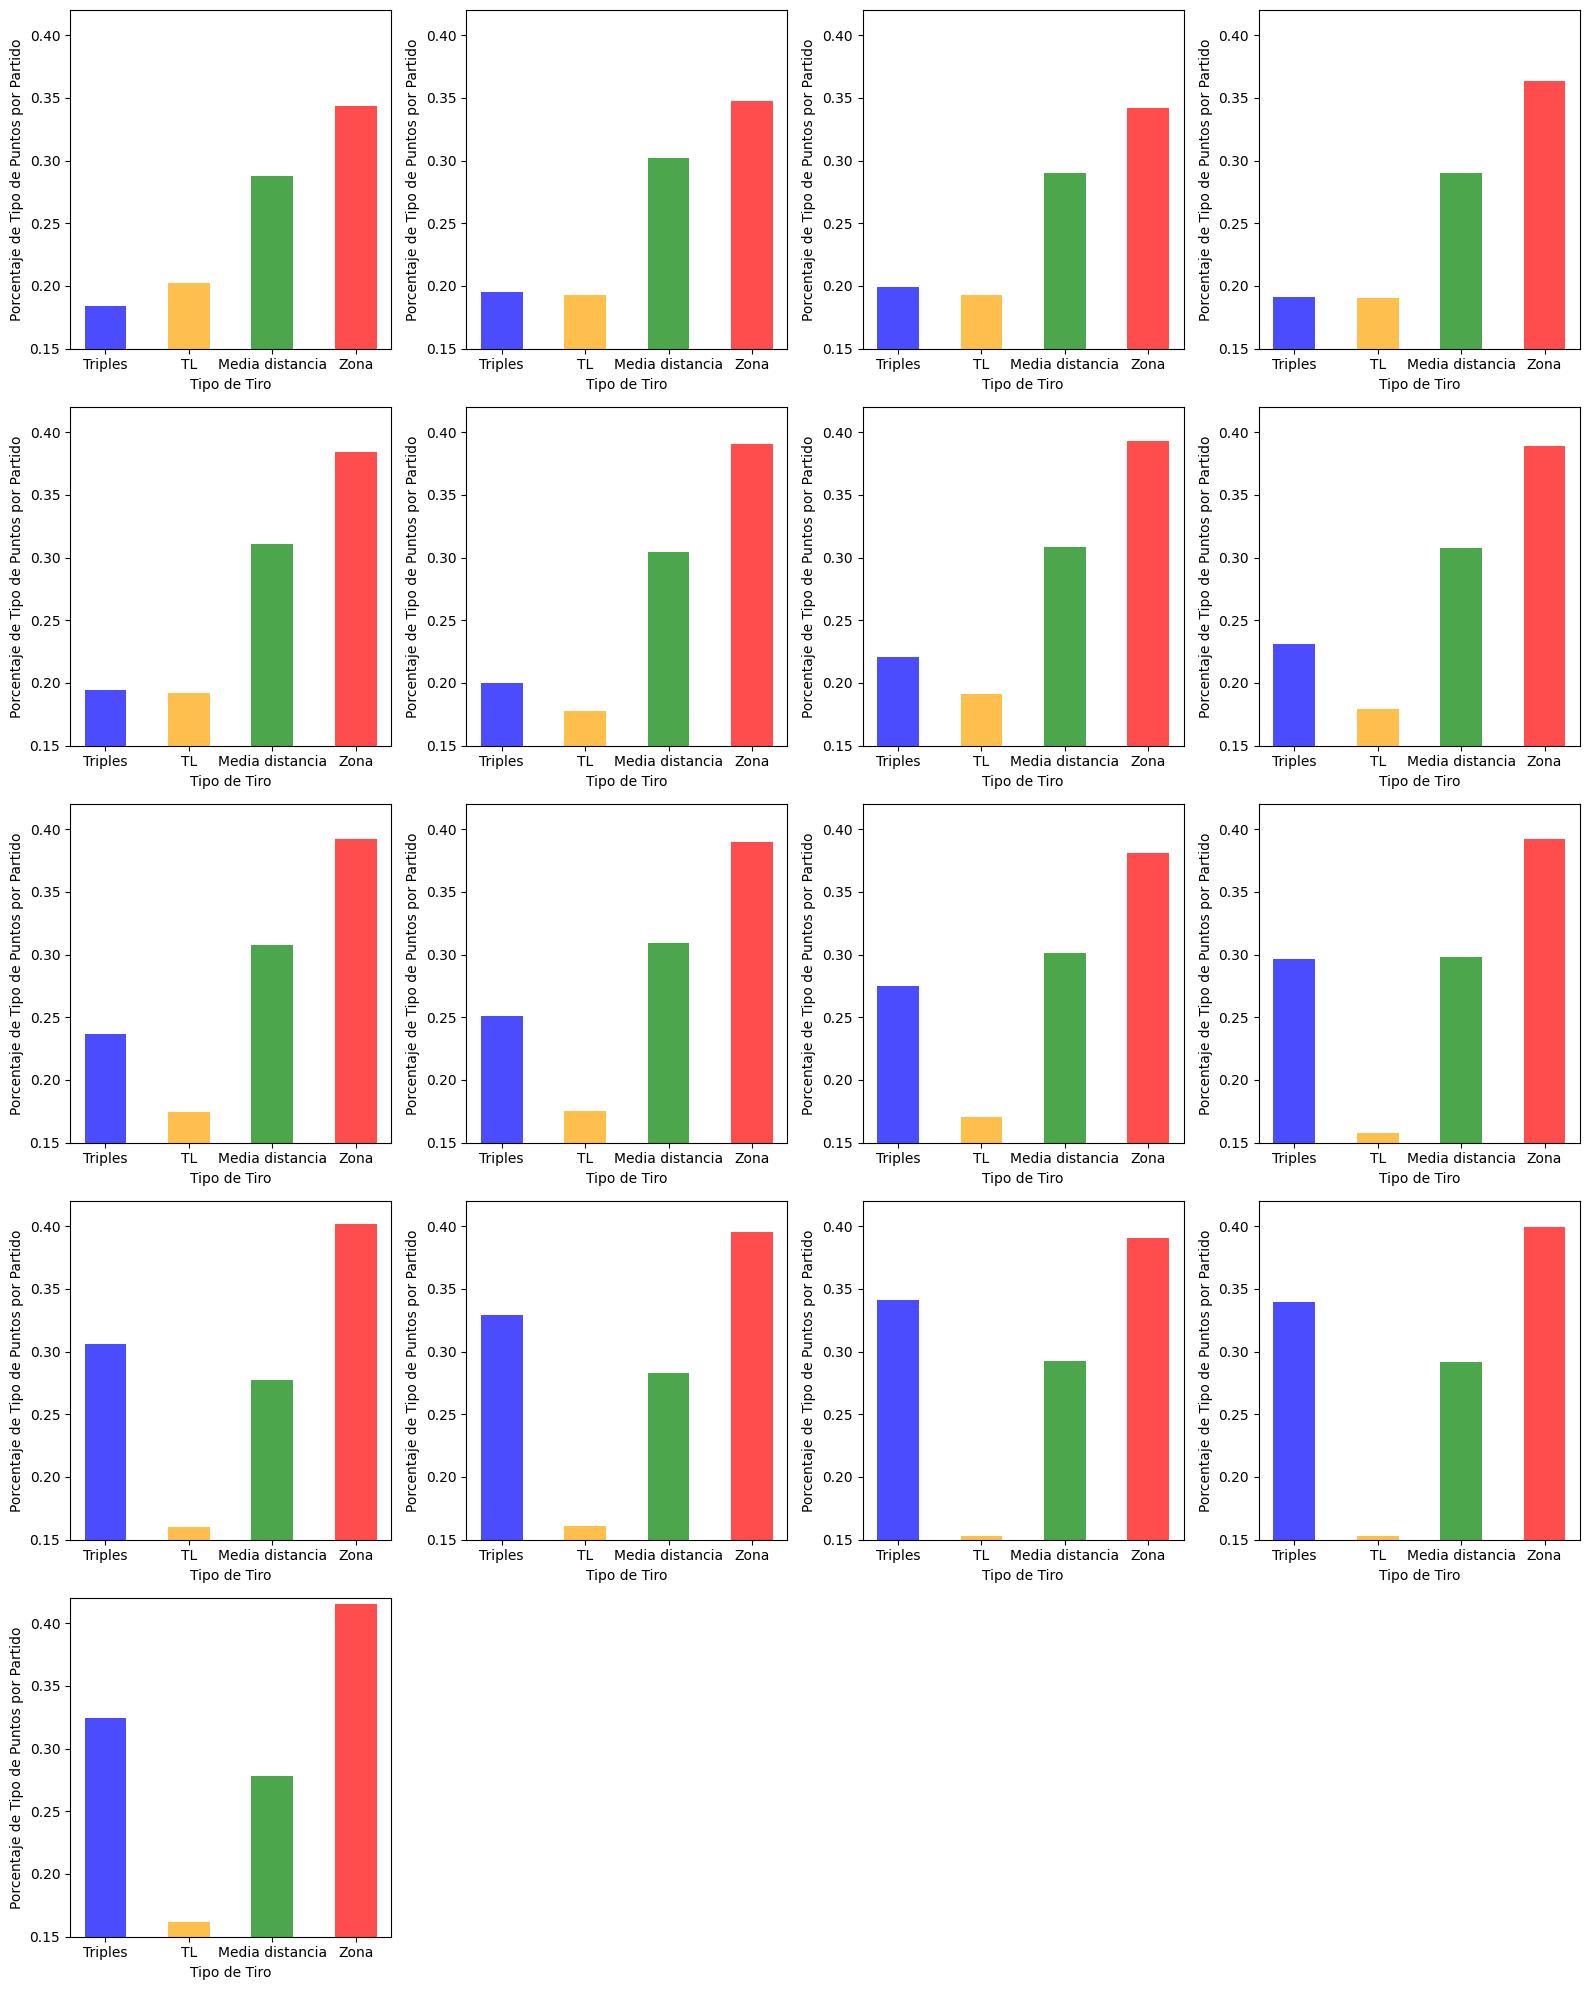

In [43]:
fig, axs = plt.subplots(5, 4, figsize=(16, 20))

for i in nba_agrupados.index:

    total_puntos_por_partido = nba_medias['Media Puntos'][i]
    puntos_por_partido_triples = nba_medias['Media Puntos Triples'][i] / total_puntos_por_partido
    puntos_por_partido_tiros_libres = nba_medias ['Media Puntos Tiros Libres'][i] / total_puntos_por_partido
    puntos_por_partido_tiros_de_2 = nba_medias['Media Puntos de media distancia'][i] / total_puntos_por_partido
    puntos_por_partido_tiros_en_zona = nba_medias['Media Puntos en Zona'][i] / total_puntos_por_partido

    # Crear un gráfico de pie para la temporada 
    ax = axs[i // 4, i % 4]
    ax.bar(['Triples', 'TL', 'Media distancia', 'Zona'],
           [puntos_por_partido_triples , puntos_por_partido_tiros_libres, puntos_por_partido_tiros_de_2, puntos_por_partido_tiros_en_zona],
            color=['blue', 'orange', 'green', 'red'],  # Cambiar colores de las barras
            alpha=0.7,  # Cambiar la transparencia de las barras
            width=0.5)  # Cambiar el ancho de las barras)
    #ax.set_title(f'Temporada {2006+i}')
    ax.set_ylim(0.15, 0.42)
    ax.set_xlabel('Tipo de Tiro')
    ax.set_ylabel('Porcentaje de Tipo de Puntos por Partido')
    
for i in range(17, 20):
    fig.delaxes(axs[i // 4, i % 4])

# Mostrar los gráficos
plt.tight_layout()
plt.show()

## Es el momento de especializarlo por equipos
#### Los equipos de la Conferencia Oeste escogidos (sin contar GSW) son: OKC, Clippers, Memphis, Spurs
#### Los equipos de la Conferencia Este escogidos son: Cleveland, Toronto, Boston, Miami

- Guardo el dataframe en un nuevo csv para posterior tratamiento

In [385]:
nba.to_csv('nba.csv', index = False)